In [ ]:
#Doing PCA with the entire traj

In [1]:
import pyemma
import glob
import numpy as np
import pyemma.plots as mplt
%pylab inline
import mdtraj as md
import pyemma.coordinates as coor
 
def average_by_state(dtraj, x, nstates):
    assert(len(dtraj) == len(x))
    N = len(dtraj)
    res = np.zeros((nstates))
    for i in range(nstates):
        I = np.argwhere(dtraj == i)[:,0]
        res[i] = np.mean(x[I])
    return res
 
def avg_by_set(x, sets):
    # compute mean positions of sets. This is important because of some technical points the set order
    # in the coarse-grained TPT object can be different from the input order.
    avg = np.zeros(len(sets))
    for i in range(len(sets)):
        I = list(sets[i])
        avg[i] = np.mean(x[I])
    return avg


Populating the interactive namespace from numpy and matplotlib


In [2]:
trajfile = []
for i in range(1,6):
    path = '/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_md'+str(i)+'.nc'
    trajfile.append(path)
print(trajfile)
#assigns the features
feat = coor.featurizer("/net/jam-amaro-shared/bccgc4/Strided_Traj/protein.h5")
feat.add_all()
print(feat.describe()[:13])

#defining the trajs and features without loading into memory
inp = coor.source(trajfile, feat)
print(inp)
print('trajectory length = ',inp.trajectory_length(0))
print('number of dimension = ',inp.dimension())

['/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_md1.nc', '/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_md2.nc', '/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_md3.nc', '/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_md4.nc', '/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_md5.nc']
['ATOM:ACE 0 H1 0 x', 'ATOM:ACE 0 H1 0 y', 'ATOM:ACE 0 H1 0 z', 'ATOM:ACE 0 CH3 1 x', 'ATOM:ACE 0 CH3 1 y', 'ATOM:ACE 0 CH3 1 z', 'ATOM:ACE 0 H2 2 x', 'ATOM:ACE 0 H2 2 y', 'ATOM:ACE 0 H2 2 z', 'ATOM:ACE 0 H3 3 x', 'ATOM:ACE 0 H3 3 y', 'ATOM:ACE 0 H3 3 z', 'ATOM:ACE 0 C 4 x']


trajectory length =  90000
number of dimension =  9972


In [3]:
#running PCA

pca_obj=coor.pca(inp, dim= -1, var_cutoff=0.95) # all possible dimensions, execpt those limited by retained variance


Text(0, 0.5, 'principal comp. 2')

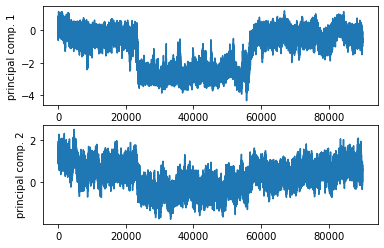

In [4]:
# this is looking at the first two PC's

Ypca = pca_obj.get_output()[0]

subplot2grid((2,1),(0,0))
plot(Ypca[:,0])
ylabel('principal comp. 1')
subplot2grid((2,1),(1,0))
plot(Ypca[:,1])
ylabel('principal comp. 2')

In [5]:
#This is clustering the PCA results by kmeans
Ypca = pca_obj.get_output()

cl = coor.cluster_kmeans(data=Ypca,k=10,max_iter=5000)

cl.converged

True

In [6]:
#defining discrete trajectories

dtrajs = cl.dtrajs
print(dtrajs)
print(np.size(dtrajs))

[array([4, 4, 4, ..., 6, 6, 6], dtype=int32), array([4, 4, 4, ..., 3, 3, 3], dtype=int32), array([4, 4, 4, ..., 9, 9, 9], dtype=int32), array([4, 4, 4, ..., 0, 0, 0], dtype=int32), array([4, 4, 4, ..., 5, 5, 5], dtype=int32)]
450000


[ 0.10598533 -0.23933104 -2.5773234  -2.5571575   1.3708994   1.1992224
 -0.246718   -0.4901709   1.4184754   0.89356387]
[ 2.1273336   2.8142629  -0.3033279  -0.877679    0.25431877 -0.9237314
  0.57554257 -0.16706836 -0.49594167 -1.6135513 ]


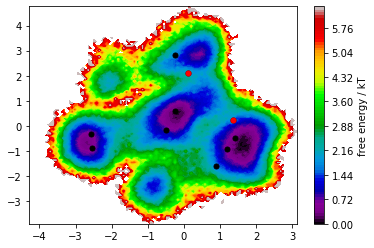

In [7]:
#plotting free energy plot and cluster centroids

mplt.plot_free_energy(np.vstack(Ypca)[:,0], np.vstack(Ypca)[:,1])
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]
plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='black')

print(cc_x)
print(cc_y)

plot(cc_x[4], cc_y[4],linewidth=0, marker='o', markersize=5, color="red")
plot(cc_x[0], cc_y[0],linewidth=0, marker='o', markersize=5, color="red")

savefig('PCA_FE_nonstrided.png')

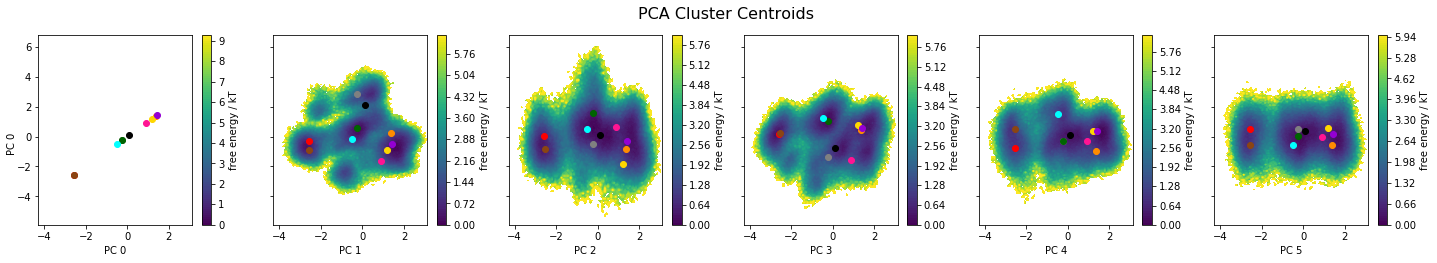

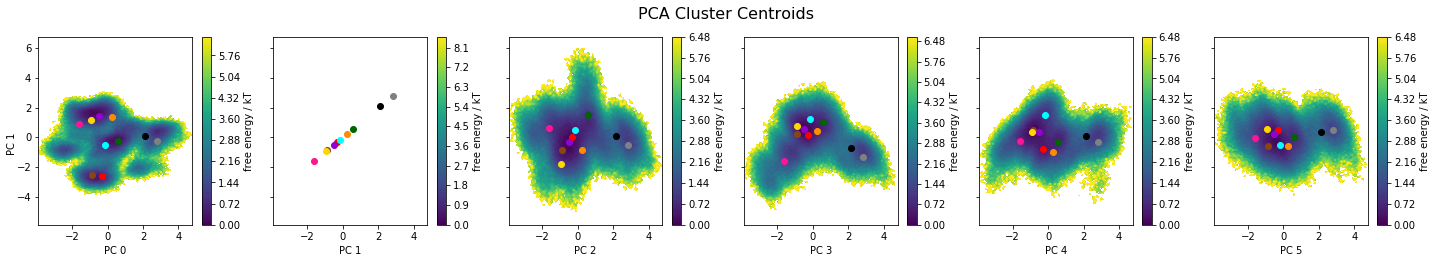

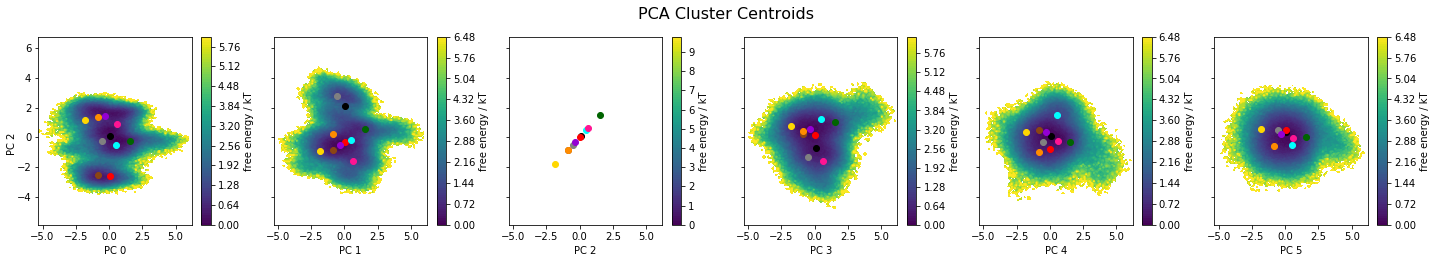

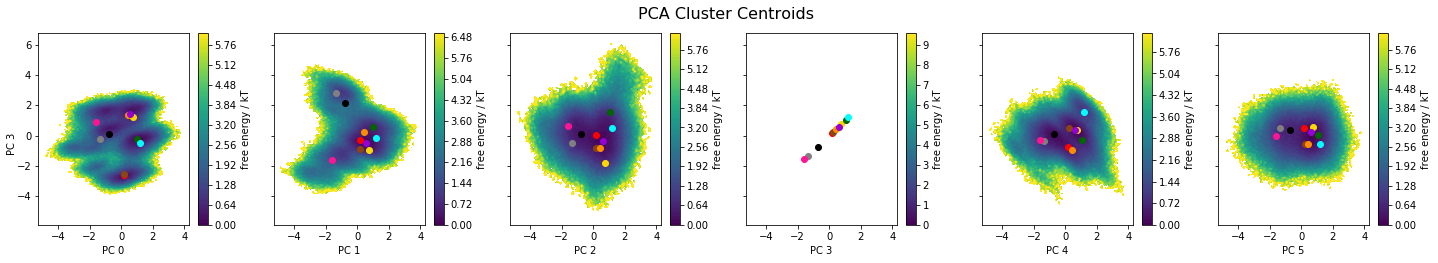

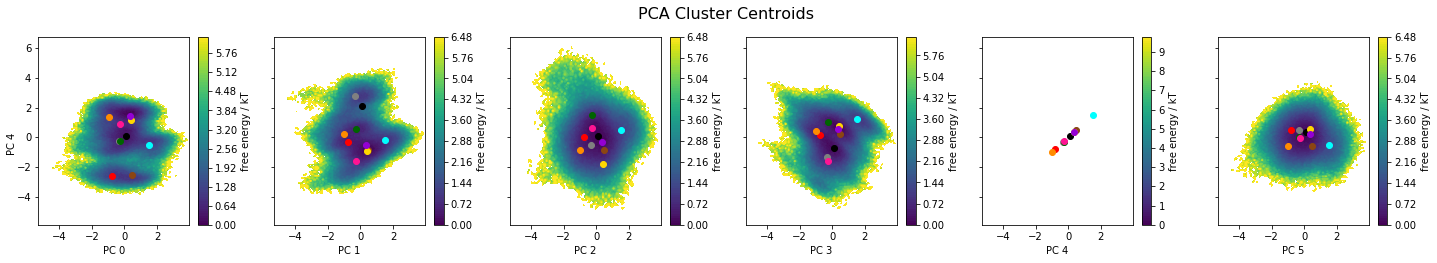

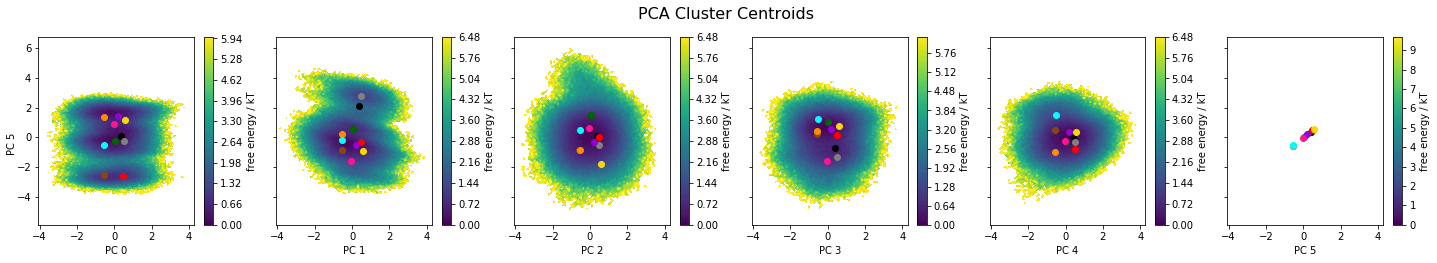

In [8]:
#plotting the free energy in subplots for tics 0-5

for s in range(6):
    fig, ax = plt.subplots(1, 6, sharex='col', sharey='row', figsize = (20,3.4)) #creating 1x6 subplot grid
    
    for w in range(6):
        mplt.plot_free_energy(np.vstack(Ypca)[:,s], np.vstack(Ypca)[:,w], ax = ax[w], cmap = 'viridis')#, cbar = False, cbar_label = None)
        cc_x = cl.clustercenters[:,s]
        cc_y = cl.clustercenters[:,w]
        #ax[w].plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='red')
        colors = ['black','gray','red','saddlebrown','darkorange','gold','darkgreen','aqua','darkviolet','deeppink']
        for i in range(10):
            ax[w].scatter(cc_x[i], cc_y[i], color = colors[i])
    
    for a in range(6):
        ax[a].set(xlabel = ('PC '+str(a)))
        
    fig.text(0.001, 0.5, 'PC '+str(s), va = 'center', rotation='vertical')
    
    fig.suptitle('PCA Cluster Centroids',fontsize = 16, y=1.06)
    fig.tight_layout()

    plt.savefig('/home/jegan/Clustering_methods/PCA/figs/PCA_all_atoms_FE/PCA_FE_PC'+str(s)+'.png', bbox_inches = 'tight')


In [9]:
print(np.size(pca_obj.cumvar))
print(pca_obj.cumvar)
print(np.size(Ypca[0]))

9972
[0.04120049 0.07710884 0.10622355 ... 0.99999999 1.         1.        ]
91260000


In [12]:
#This prints the discrete trajectories we saved out before, then saves out the percent of frames in each cluster
print(dtrajs)
print(dtrajs[0])

with open('/home/jegan/Clustering_methods/PCA/clusters.txt', 'w') as newfile:
    numb = []
    for i in range(10):
        frames = []
        for k in dtrajs:
            for p in k:
                if p == i:
                    frames.append(p)

        print(len(frames))
        numb.append(len(frames))
    
    newfile.write('Percent of frames per PCA bkbnpos cluster:\n')
    tot = 0
    index = 0
    for j in numb:
        tot += j
        percent = (j/450000)*100
        num = str(percent)
        newfile.write('Cluster '+ str(index)+' = '+num+' %\n')
        index += 1
    print(tot)
#cl.index_clusters
#shape(cl.index_clusters)
#dtraj=max(dtrajs)
#print(dtraj)


[array([4, 4, 4, ..., 6, 6, 6], dtype=int32), array([4, 4, 4, ..., 3, 3, 3], dtype=int32), array([4, 4, 4, ..., 9, 9, 9], dtype=int32), array([4, 4, 4, ..., 0, 0, 0], dtype=int32), array([4, 4, 4, ..., 5, 5, 5], dtype=int32)]
[4 4 4 ... 6 6 6]
46166
29936
33260
41003
49306
32216
56301
46459
38271
77082
450000


In [ ]:
#From here on it's clustering and extracting centroids, as well as saving out the centroid coords

In [16]:
#Extracting Centroids

avg = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

indices = {}
for i in range(len(Ypca)):
    #for k in range(len(Y[0][i])):
    for k in range(len(Ypca[i])):
        c = cl.clustercenters[cl.dtrajs[i][k]]
        v = Ypca[i][k]
        newavg = np.linalg.norm(c-v)
        if avg[cl.dtrajs[i][k]] > newavg:
            avg[cl.dtrajs[i][k]] = newavg
            indices[cl.dtrajs[i][k]] = [i, k]

trajectory=md.load(['/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_md1.nc', '/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_md2.nc', '/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_md3.nc', '/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_md4.nc', '/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_md5.nc'], top="/net/jam-amaro-shared/bccgc4/Strided_Traj/protein.h5")

z = 0
for key in indices:
        z = z + 1
        index = indices[key][1]*(1 + indices[key][0])
        print(index)
        i = trajectory[index].topology.select("protein")
        new_traj = trajectory[index].atom_slice(i)
        new_traj.save_pdb('/home/jegan/Clustering_methods/PCA/PCA_nonstrided_centroids/PCA_%s.pdb' % (z-1))

2685
23221
352940
44085
143870
74278
54120
183012
198575
389105


In [14]:
#I think this is for saving out parts of the traj for each cluster

Clusters={}

for count in range(0,10):
    frames=[]
    indices = [d for d, x in enumerate(dtraj) if x == count]
    frames.append(indices)
    Clusters[count]=frames

% store Clusters

for key in Clusters:
    print(key)
    a=traj[Clusters[key]]

    a.save_xtc('/net/jam-amaro-shared/bccgc4/PCA/Trajectories/Traj_0.95-'+str(key)+".xtc")
    print(a)